In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = "./chest_xray/"
sz=224
arch=dn121
bs=32

In [3]:
os.listdir(PATH)

['test', 'valid', 'models', 'train', 'tmp']

In [4]:
os.listdir(f'{PATH}valid')

['PNEUMONIA', 'NORMAL']

In [5]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

In [6]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


epoch      trn_loss   val_loss   accuracy                  
    0      0.16891    0.540759   0.788462  
    1      0.104419   0.564867   0.826923                  
    2      0.088818   0.572297   0.814103                   



[array([0.5723]), 0.8141025656308883]

In [7]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      0.072392   0.623418   0.817308  
    1      0.063171   0.587599   0.828526                   
    2      0.058041   0.65812    0.815705                   



[array([0.65812]), 0.8157051297334524]

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [9]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [101]:
learn.fit(1e-2, 1)

  0%|          | 0/164 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                     
    0      0.107894   0.276379   0.913462  



[array([0.27638]), 0.9134615384615384]

In [11]:
learn.precompute=False

In [12]:
learn.fit(1e-2, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.118502   0.467024   0.88141   



[array([0.46702]), 0.8814102564102564]

In [13]:
learn.unfreeze()

In [14]:
lr=np.array([1e-4,1e-3,1e-2])

In [15]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.118351   0.351281   0.894231  
    1      0.113167   0.393778   0.891026                    
    2      0.084577   0.440693   0.883013                     
    3      0.081324   0.380416   0.908654                     
    4      0.07762    0.356607   0.910256                     
    5      0.062957   0.421648   0.884615                     
    6      0.04909    0.36223    0.900641                     



[array([0.36223]), 0.9006410256410257]

In [16]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [17]:
accuracy_np(probs, y)

0.8878205128205128

In [137]:
log_pred_val = learn.predict()
log_pred_val.shape

(624, 2)

In [138]:
# log_pred_val = np.argmax(log_pred_val, axis=1)
log_pred_val = np.max(log_pred_val, axis=1)
prob_val = np.exp(log_pred_val)
#accuracy(log_pred_val, y)

In [139]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y.ravel(), log_pred_val.ravel())

In [141]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)
print(auc)

0.7634122287968442


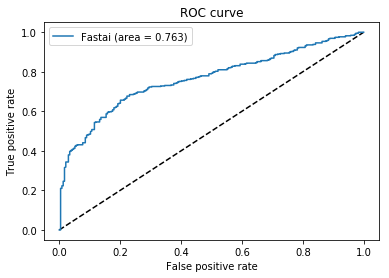

In [142]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Fastai (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Performance Matrix

In [115]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [116]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[167  67]
 [  3 387]]


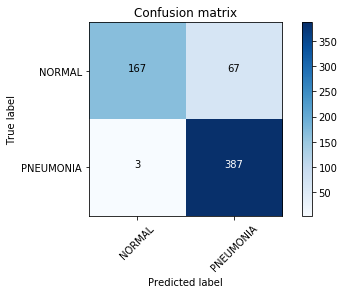

In [117]:
plot_confusion_matrix(cm, data.classes)

In [120]:
accuracy_np(preds, y)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
m = arch(True)

In [ ]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [ ]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [ ]:
data.val_ds

In [ ]:
learn = ConvLearner.from_model_data(m, data)

In [ ]:
learn.freeze_to(-4)

In [ ]:
m[-1].trainable

In [ ]:
m[-4].trainable

In [ ]:
learn.fit(0.01, 1)

In [ ]:
learn.fit(0.01, 1, cycle_len=1)

### CAM

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [ ]:
# x, y = next(iter(data.trn_dl))

In [ ]:
x,y = next(iter(data.val_dl))

In [ ]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

In [ ]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [ ]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [ ]:
%time py = m(Variable(x.cuda()))

In [ ]:
for o in sfs: o.remove()

In [ ]:
[o.features.size() for o in sfs]

In [ ]:
py = np.exp(to_np(py)[0]); py

In [ ]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

In [ ]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

In [ ]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

In [ ]:
# Plot ROC Curve
evaluate.plot_roc_curve(np.array(probs), y)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
plot_roc(preds,y)